# Fields Spatial Distribution Analysis

In [1]:
%load_ext autoreload
%autoreload 2

##### Environment Setup

In [2]:
import sys
from pathlib import Path

## Libraries import
import numpy as np
import pandas as pd
import skimage as ski
import skimage.morphology as skimorph
import skimage.measure as skimeasure
import skimage.feature as skifeature
from skimage.measure import regionprops
import scipy as sci
import scipy.stats as stats
import cv2 as cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import skimage.future.graph as skigraph
import networkx as nx

sys.path.extend(['/home/prf/PycharmProjects/RinocitologiaImageSimilarity']) # make project code visible

# Project import
from utils.sampling import Sampler
from utils.reporting import LatexDoc
from processing.metrics import *
from processing.image_processing import *


#Setup the environment
np.random.seed(1994)

generated_dir = Path("generated")
generated_dir.mkdir(exist_ok=True)
report_doc = LatexDoc()

sm_color = "#3498db"
cyt_color = "#f39c12"
mpl.rcParams['font.family']  = 'sans-serif'
mpl.rcParams['font.serif']  = 'Helvetica'

LOAD_PREVIOUS_RESULTS = False

In [3]:
def quantiles_indeces(array): ## quick utility function
    return[0, 
           np.around(len(array)/4).astype(np.intp), 
           np.around(len(array)/2).astype(np.intp),
           np.around(3*len(array)/4).astype(np.intp),
           -1]

## Sampling Datasets and Load Field Images

In [4]:
sm_sampler = Sampler(seed=420, in_dir="../Datasets/Fields/Smear")
cyt_sampler = Sampler(seed=420, in_dir="../Datasets/Fields/Cytospin")

nsamples = 450
sm_images = ski.io.imread_collection(sm_sampler.sampling(sample_size=nsamples))
cyt_images =  ski.io.imread_collection(cyt_sampler.sampling(sample_size=nsamples))
print("Smeared dataset size: {}, sampled {} images".format(sm_sampler.get_dataset_size(), len(sm_images)))
print("Cytospin dataset size: {}, sampled {} images".format(cyt_sampler.get_dataset_size(), len(cyt_images)))
print("Sample size differs of: {}".format(np.abs(len(cyt_images) - len(sm_images))))


# Get an equal number of samples
min_samples = min(len(sm_images),len(cyt_images))
sm_images = sm_images[0:min_samples]
cyt_images = cyt_images[0:min_samples]

print("Smeared dataset size: {}, sampled {} images".format(sm_sampler.get_dataset_size(), len(sm_images)))
print("Cytospin dataset size: {}, sampled {} images".format(cyt_sampler.get_dataset_size(), len(cyt_images)))
print("Sample size differs of: {}".format(np.abs(len(cyt_images) - len(sm_images))))

report_doc.add_variable("sm_dataset_size", sm_sampler.get_dataset_size())
report_doc.add_variable("cyt_dataset_size", cyt_sampler.get_dataset_size())
report_doc.add_variable("sample_size", nsamples)
report_doc.add_variable("sample_min_size", min_samples)

Smeared dataset size: 587, sampled 424 images
Cytospin dataset size: 454, sampled 388 images
Sample size differs of: 36
Smeared dataset size: 587, sampled 388 images
Cytospin dataset size: 454, sampled 388 images
Sample size differs of: 0


##### Select random images as examples

In [5]:
sm_img_index = np.random.randint(0,len(sm_images)+1)
cyt_img_index = np.random.randint(0,len(cyt_images)+1)

## Density Analysis

#### Preprocessing: Binarization

In [6]:
%%time
if not LOAD_PREVIOUS_RESULTS:
    sm_binary = np.asarray([binarization(img) for img in sm_images])
    cyt_binary = np.asarray([binarization(img) for img in cyt_images])

CPU times: user 14min 25s, sys: 4.69 s, total: 14min 30s
Wall time: 12min 20s


##### Preprocessing steps visualization

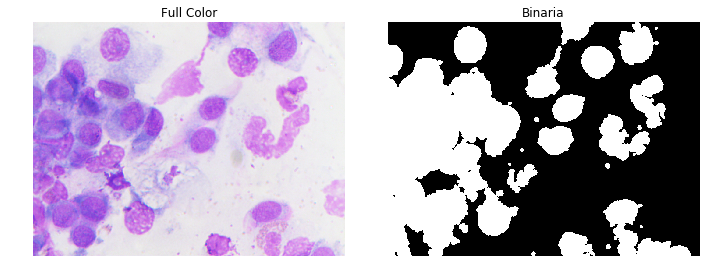

In [7]:
fig, ax = plt.subplots(ncols=2,figsize=(10,8))

sm_img = sm_images[sm_img_index]
ax[0].imshow(sm_img)
ax[0].set_title("Full Color")
ax[0].set_axis_off()

sm_binary_img = binarization(sm_img)
ax[1].imshow(sm_binary_img, cmap=mpl.cm.gray)
ax[1].set_title("Binaria")
ax[1].set_axis_off()

    
fig.tight_layout()       
fig.savefig(str(generated_dir/"density_preprocessing_steps.pdf"), bbox_inches='tight', transparent=True)

## Density Measure
Given an a **binary image** $B$ with width $w$ and height $h$. We compute the histogram $H(B)$, since $B$ is a binary image:

$$ H(B) = (h_0,h_1)$$

Where $h_0$ and $h_1$ are the **absolute frequencies** of the *background* and *foreground* pixels. We define the **density measure** of $B$ as:

$$ \delta(B) = \frac{h_1}{w\times h} $$

i.e the relative frequency of foreground pixels. Notice that: $ 0 \leq \delta(B) \leq 1$, so in dual way, we can define also the **sparsity measure** as:

$$ \sigma(B) = 1 - \delta(B) = \frac{h_0}{w \times h} $$

#### Compute density for dataset

In [8]:
%%time

if LOAD_PREVIOUS_RESULTS:
    features_df = pd.read_csv("density_dataframe.csv")
else:
    features_df = pd.DataFrame(columns=["sm_dens","cyt_dens","sm_spars","cyt_spars"])

    features_df["sm_dens"] = np.asarray([density(img) for img in sm_binary])
    features_df["cyt_dens"] = np.asarray([density(img) for img in cyt_binary])

    features_df["sm_spars"] = 1 - features_df["sm_dens"]
    features_df["cyt_spars"] = 1 - features_df["cyt_dens"]

    features_df.to_csv("density_dataframe.csv", index=False)  


CPU times: user 2.34 s, sys: 0 ns, total: 2.34 s
Wall time: 2.45 s


##### Visualize rapresentative samples

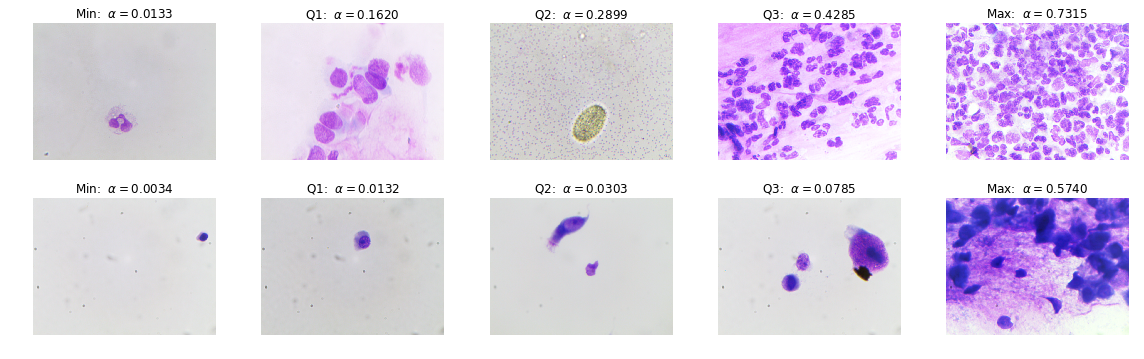

In [9]:
sm_dens_ndarray = features_df['sm_dens'].to_numpy()
sm_indeces = np.argsort(sm_dens_ndarray)[quantiles_indeces(sm_dens_ndarray)]

cyt_dens_ndarray = features_df['cyt_dens'].to_numpy()
cyt_indeces = np.argsort(cyt_dens_ndarray)[quantiles_indeces(cyt_dens_ndarray)]
    

titles= ['Min', 'Q1', 'Q2', 'Q3', 'Max']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,5))
for index, q, title, ax in zip(sm_indeces, sm_dens_ndarray[sm_indeces], titles, axes[0]):
    ax.imshow(sm_images[index])
    ax.set_title("{}:  $\\alpha={:.4f}$".format(title, q))
    ax.set_axis_off()

for index, q, title, ax in zip(cyt_indeces, cyt_dens_ndarray[cyt_indeces], titles,  axes[1]):
    ax.imshow(cyt_images[index])
    ax.set_title("{}:  $\\alpha={:.4f}$".format(title, q))
    ax.set_axis_off()


fig.tight_layout()
fig.savefig(str(generated_dir/"density_examples.pdf"), bbox_inches='tight', transparent=True)


##### Density distributions analysis

##### VIsualize Distributions Histrograms

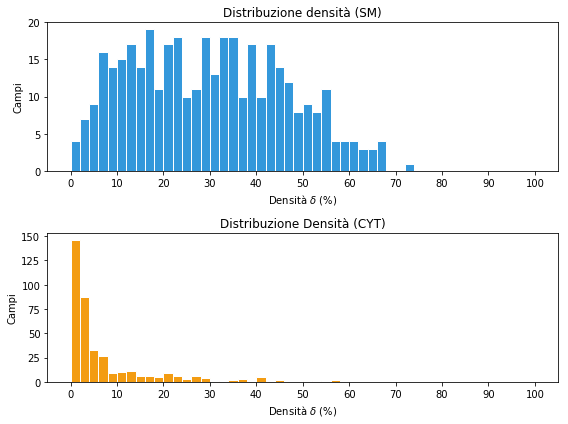

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(8,6))

# Smear Histogram
ax[0].hist(features_df["sm_dens"]*100, bins=50, range=[0,100],
           color= sm_color, edgecolor="white", label="Smeared")

ax[0].set_title("Distribuzione densità (SM)")
ax[0].set_xticks(np.arange(0,110,10))
ax[0].set_xlabel("Densità $\\delta$ (%)")
ax[0].set_ylabel("Campi")
#ax[0].xaxis.set_major_formatter(mpl.ticker.PercentFormatter())


## Cytospin Histogram
ax[1].hist(features_df["cyt_dens"]*100, bins=50, range=[0,100], 
           color=cyt_color, edgecolor="white", label="Cytospin")
ax[1].set_title("Distribuzione Densità (CYT)")
ax[1].set_xticks(np.arange(0,110,10))
ax[1].set_xlabel("Densità $\\delta$ (%)")
ax[1].set_ylabel("Campi")
#ax[1].xaxis.set_major_formatter(mpl.ticker.PercentFormatter())

fig.tight_layout()
fig.savefig(str(generated_dir/"density_histograms.pdf"), bbox_inches='tight', transparent=True)

##### VIsualize Distribution Boxplots

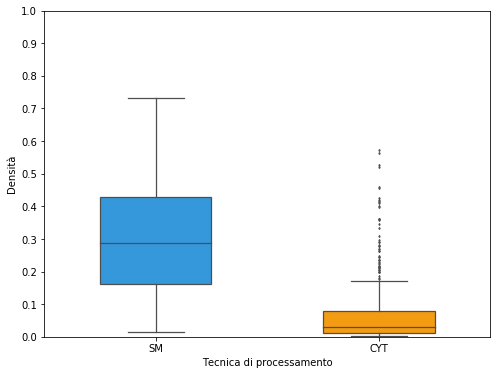

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
sns.boxplot(data=features_df[['sm_dens','cyt_dens']], width=0.5, fliersize=1.5, linewidth=1.25, saturation=1.0, palette=[sm_color,cyt_color], ax=ax)
ax.set_ylabel('Densità')
ax.set_xlabel('Tecnica di processamento')
ax.set_xticklabels(['SM','CYT'])
ax.set_ylim([0.0,1.0])
ax.set_yticks(np.arange(0,1.1,0.1))

fig.savefig(str(generated_dir / "density_boxplot.pdf"), bbox_inches='tight', transparent=True)

The smeared and cytospin population have 157 samples, each one is a field image.

As we can see from the histogram plot, the cytospin variable seems to fit to an *exponential distribution*: almost the entire population have a density value between $0\%-5\%$, with a typical **exponential decay towards middle density values** and practically no image have a density over $50\%$.

The smear variable have a **skewed distribution**: the population is much more **uniform** with density values in a more **spreaded range** between $5\%-45\%$. In this case, no image have a density over $75\%$.







### Normality test
From the distributions histogram plot seems that samples from both distribution doesn'tdistributes normally, especially the CYT one.
We choose **Shapiro-Wilkinson** as normality test with a confidence level of $95\%$

In [12]:
s,p = stats.shapiro(features_df["sm_dens"])
print("p-value: {}".format(p))
if p <= 0.05:
    print("H0 rejected")

p-value: 1.237381752616784e-06
H0 rejected


In [13]:

s,p = stats.shapiro(features_df["cyt_dens"])
print("p-value: {}".format(p))
if p <= 0.05:
    print("H0 rejected")

p-value: 6.928079996210161e-27
H0 rejected


both $p$-values are less than $0.05$, we can reject the null hypothesis of normally distributed samples from the test

##### Descriptive statistics

In [14]:
density_stats = features_df[['sm_dens','cyt_dens']].describe()

#remove useless statistics
density_stats.drop('mean', inplace=True)
density_stats.drop('std', inplace=True)

# add new statics
mad_scale_factors = 1 / np.quantile(features_df[['sm_dens','cyt_dens']], q=0.75, axis=0) ## https://www.r-bloggers.com/absolute-deviation-around-the-median/
mad = pd.Series(stats.median_absolute_deviation(features_df[['sm_dens','cyt_dens']],scale=mad_scale_factors),  name='MAD', index=['sm_dens','cyt_dens'])
density_stats = density_stats.append(mad)

iqr = pd.Series(stats.iqr(features_df[['sm_dens','cyt_dens']].to_numpy(), axis=0), name='IQR', index=['sm_dens','cyt_dens'])
density_stats = density_stats.append(iqr)

# rename rows index and columns 
density_stats = density_stats.rename(index={'count':'# campi',
                             '25%':'Q1', 
                             '50%':'Median', 
                             '75%':'Q3'},
                     columns={'sm_dens':'Smear',
                              'cyt_dens':'Cytospin'})


In [15]:
density_stats.T

,# campi,min,Q1,Median,Q3,max,MAD,IQR
Smear,388.0,0.013307,0.161817,0.288366,0.427663,0.731466,0.312566,0.265846
Cytospin,388.0,0.003390,0.013144,0.029858,0.078013,0.573959,0.272119,0.064869


In [16]:
density_stats.T[['# campi','min','max','Q1','Median', 'Q3', 'MAD', 'IQR']].to_latex(generated_dir/'density_summary_stats_table.tex', float_format='%1.4f') #Save to table a transposed dataframe

##### Sparsity vs Density Visualization
For agument the interpetability of the measures, we present density and sparsity as percentage

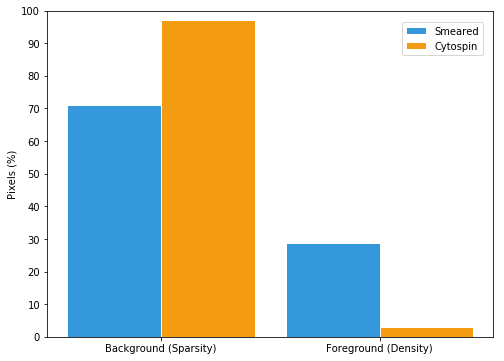

In [17]:
features_stats = features_df.describe()
bar_width=0.15
x = np.array([1,1.35])


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

sm_medians = [features_stats["sm_spars"]['50%']*100, features_stats["sm_dens"]['50%']*100] # 50% is the second qurtile, aka the median
cyt_medians = [features_stats["cyt_spars"]['50%']*100, features_stats["cyt_dens"]['50%']*100]

ax.bar(x, sm_medians , width=bar_width,
       align="edge", color="#3498db", 
       edgecolor="white", label="Smeared")

ax.bar(x+bar_width, cyt_medians, width=bar_width,
       align="edge", color="#f39c12",
       edgecolor="white", label="Cytospin") 


ax.set_xticks(x+bar_width)
ax.set_xticklabels(["Background (Sparsity)","Foreground (Density)"])
ax.set_ylim((0,100))
ax.set_yticks(np.arange(0,110,10))
#ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
ax.set_ylabel("Pixels (%)")
ax.legend(loc='upper left', bbox_to_anchor=(0.785,0.98), ncol=1)

fig.savefig(str(generated_dir/"avg_sparsity_density_barplot.pdf"), bbox_inches='tight', transparent=True)





## Agglomeration Analysis



In [18]:
def detect_cells(image):
    
    binar = binarization(image)

    dist_map = sci.ndimage.distance_transform_edt(binar)
    local_max = skifeature.peak_local_max(dist_map, indices=False, min_distance=25,
                                       labels=binar)

    # perform a connected component analysis on the local peaks,
    # using 8-connectivity, then apply the Watershed algorithm
    markers = sci.ndimage.label(local_max, structure=np.ones((3, 3)))[0]
    labels = skimorph.watershed(-dist_map, markers, mask=binar)
      
    return filter_labels(labels)

def compute_rag(labels, weighted=False):
      
    rag = skigraph.RAG(labels, connectivity=2)
    rag.remove_node(0)
    rag.nodes
    
    if weighted:
        inters_map, info = intersection_map(labels)
        for u,v in rag.edges:
         rag.edges[u,v]['weight'] = info[u,v] #region intersection as (u,v) edge's weight
    
    for node,region in zip(rag.nodes, regionprops(labels)):
        rag.nodes[node]['label'] = region.label
        rag.nodes[node]['centroid'] = region.centroid
        rag.nodes[node]['area'] = region.area
        
    return rag

def agglomeration(img):
    labels = detect_cells(img)
    rag = compute_rag(labels)
    
    return len(rag.edges)/(2*len(rag.nodes))

#### Preprocessing: cell detection and rag conversion

In [19]:
def draw_rag(rag, ax):
    rad = 12
    ## draw edges
    
    if len(rag.edges) != 0:
        for u,v in rag.edges():

            xu, yu = map(int, rag.node[u]['centroid'])
            xv, yv = map(int, rag.node[v]['centroid'])   
            ax.add_artist(mpl.patches.ConnectionPatch((yu,xu),(yv,xv),'data','data'))

    #draw nodes
    for n in rag.nodes():
        x, y = map(int, rag.node[n]['centroid'])
        ax.add_artist(mpl.patches.Circle((y,x),rad))
        ax.text(y+5,x+35,rag.node[n]['label'])


##### visualize preprocessing steps

[]

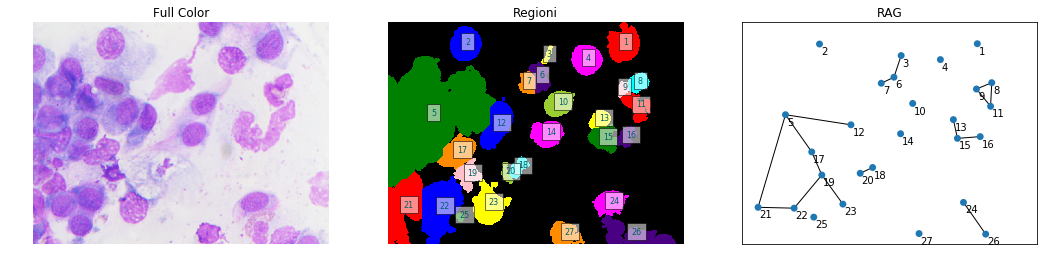

In [20]:
img = sm_images[sm_img_index]
labels = detect_cells(img)
rag = compute_rag(labels)

images = [img, 
          ski.color.label2rgb(labels, bg_label=0), 
          np.ones(sm_img.shape)]


fig, axes = plt.subplots(ncols=3, figsize=(18, 10))
titles = ['Full Color', 'Regioni', 'RAG']

for region in regionprops(labels):
    x,y = region.centroid
    axes[1].text(y, x, str("{}".format(region.label)), 
                    fontdict={'size':8}, color='#006060',
                    bbox=dict(facecolor='white', alpha=0.55,linewidth=None))

draw_rag(rag, axes[2])  
for img, title, ax in zip(images, titles, axes):
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_title(title)
axes[2].set_axis_on()  
axes[2].set_xticks([])
axes[2].set_yticks([])

[]

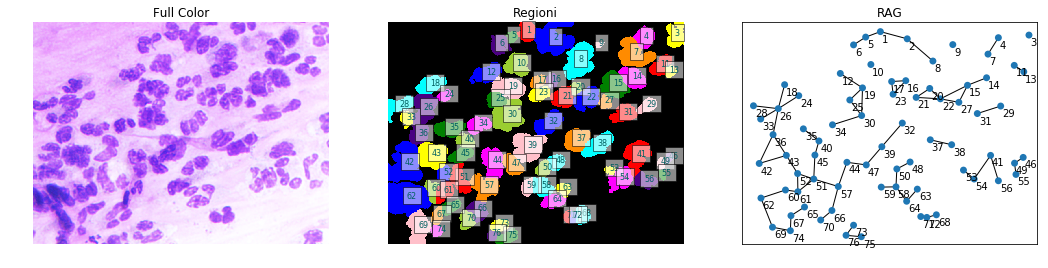

In [21]:
img = sm_images[sm_indeces[-2]]
labels = detect_cells(ski.img_as_ubyte(img))
rag = compute_rag(labels)

images = [img, 
          ski.color.label2rgb(labels, bg_label=0), 
          np.ones(sm_img.shape)]


fig, axes = plt.subplots(ncols=3, figsize=(18, 10))
titles = ['Full Color', 'Regioni', 'RAG']

for region in regionprops(labels):
    x,y = region.centroid
    axes[1].text(y, x, str("{}".format(region.label)), 
                    fontdict={'size':8}, color='#006060',
                    bbox=dict(facecolor='white', alpha=0.55,linewidth=None))

draw_rag(rag, axes[2])  
for img, title, ax in zip(images, titles, axes):
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_title(title)
axes[2].set_axis_on()  
axes[2].set_xticks([])
axes[2].set_yticks([])

#### Compute agglomerations for dataset

In [22]:
%%time
if not LOAD_PREVIOUS_RESULTS:
    sm_agglomerations = np.asarray([agglomeration(img) for img in sm_images])
    cyt_agglomerations = np.asarray([agglomeration(img) for img in cyt_images])

CPU times: user 52min 31s, sys: 11.2 s, total: 52min 42s
Wall time: 46min 35s


In [23]:
if LOAD_PREVIOUS_RESULTS:
    agglomeration_df = pd.read_csv("agglomeration_dataframe.csv")
else:
    agglomeration_df = pd.DataFrame({'sm':sm_agglomerations,
                                     'cyt':cyt_agglomerations})
    agglomeration_df.to_csv("agglomeration_dataframe.csv", index=False) 

#### visualize rapresentative examples

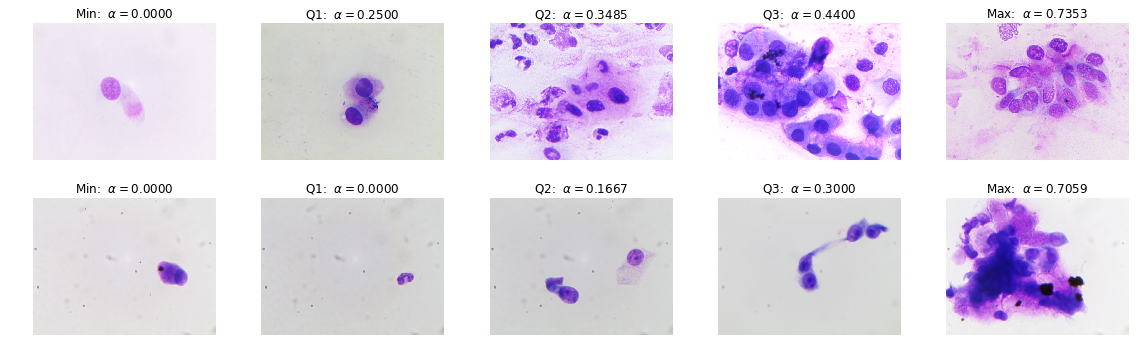

In [24]:
sm_aggl_ndarray = agglomeration_df['sm'].to_numpy()
sm_indeces = np.argsort(sm_aggl_ndarray)[quantiles_indeces(sm_aggl_ndarray)]
sm_quantiles = sm_aggl_ndarray[sm_indeces]

cyt_aggl_ndarray = agglomeration_df['cyt'].to_numpy()
cyt_indeces = np.argsort(cyt_aggl_ndarray)[quantiles_indeces(cyt_aggl_ndarray)] 
cyt_quantiles = cyt_aggl_ndarray[cyt_indeces]


titles= ['Min', 'Q1', 'Q2', 'Q3', 'Max']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,5))

for index, q, title, ax in zip(sm_indeces, sm_quantiles, titles, axes[0]):
    ax.imshow(sm_images[index])
    ax.set_title("{}:  $\\alpha={:.4f}$".format(title, q))
    ax.set_axis_off()

for index, q, title, ax in zip(cyt_indeces, cyt_quantiles, titles,  axes[1]):
    ax.imshow(cyt_images[index])
    ax.set_title("{}:  $\\alpha={:.4f}$".format(title, q))
    ax.set_axis_off()


fig.tight_layout()
fig.savefig(str(generated_dir/"agglomeration_examples.pdf"), bbox_inches='tight', transparent=True)

#### Distribution Analysis

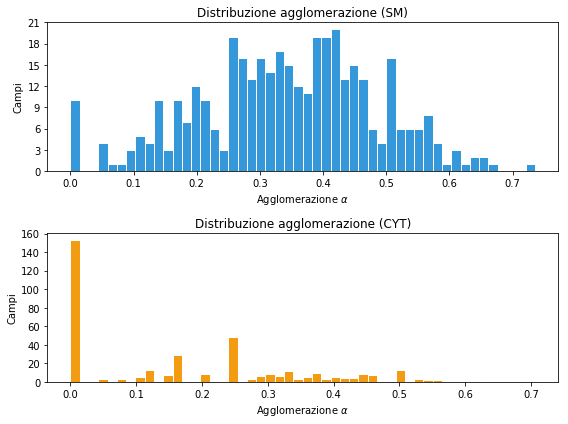

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(8,6))

# Smear Histogram
ax[0].hist(agglomeration_df["sm"], bins=50,
           color= sm_color, edgecolor="white", label="SM")

ax[0].set_title("Distribuzione agglomerazione (SM)")
#ax[0].set_xticks(np.arange(0,110,10))
ax[0].set_xlabel("Agglomerazione $\\alpha$")
ax[0].set_ylabel("Campi")
ax[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))



## Cytospin Histogram
ax[1].hist(agglomeration_df["cyt"], bins=50, 
           color=cyt_color, edgecolor="white", label="CYT")
ax[1].set_title("Distribuzione agglomerazione (CYT)")
#ax[1].set_xticks(np.arange(0,110,10))
ax[1].set_xlabel("Agglomerazione $\\alpha$")
ax[1].set_ylabel("Campi")
ax[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig.tight_layout()
fig.savefig(str(generated_dir/"agglomeration_histograms.pdf"), bbox_inches='tight', transparent=True)

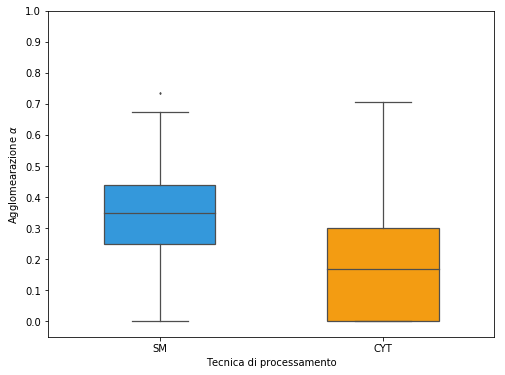

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
sns.boxplot(data=agglomeration_df[['sm','cyt']], width=0.5, fliersize=1.5, linewidth=1.25, saturation=1.0, palette=[sm_color,cyt_color], ax=ax)
ax.set_ylabel('Agglomearazione $\\alpha$')
ax.set_xlabel('Tecnica di processamento')
ax.set_xticklabels(['SM','CYT'])
ax.set_ylim([-0.05,1])
ax.set_yticks(np.arange(0,1.1,0.1))

fig.savefig(str(generated_dir / "agglomeration_boxplot.pdf"), bbox_inches='tight', transparent=True)

#### summary statistics

In [27]:
agglomeration_stats = agglomeration_df[['sm','cyt']].describe()

#remove useless statistics
agglomeration_stats.drop('mean', inplace=True)
agglomeration_stats.drop('std', inplace=True)

# add new statics
mad_scale_factors = 1 / np.quantile(agglomeration_df[['sm','cyt']], q=0.75, axis=0) ## https://www.r-bloggers.com/absolute-deviation-around-the-median/
mad = pd.Series(stats.median_absolute_deviation(agglomeration_df[['sm','cyt']],scale=mad_scale_factors),  name='MAD', index=['sm','cyt'])
agglomeration_stats = agglomeration_stats.append(mad)

iqr = pd.Series(stats.iqr(agglomeration_df[['sm','cyt']].to_numpy(), axis=0), name='IQR', index=['sm','cyt'])
agglomeration_stats = agglomeration_stats.append(iqr)

# rename rows index and columns 
agglomeration_stats = agglomeration_stats.rename(index={'count':'# campi',
                             '25%':'Q1', 
                             '50%':'Median', 
                             '75%':'Q3'},
                     columns={'sm':'Smear',
                              'cyt':'Cytospin'})

##### Export density and agglomeration summary tables as single table 

In [28]:
iterables = [['Densità', 'Agglomerazione'], ['SM', 'CYT']]
r=pd.MultiIndex.from_product(iterables)
summary_df = pd.concat([density_stats.T,agglomeration_stats.T])
summary_df.index = r
summary_df.T

Densità             Agglomerazione            
                 SM         CYT             SM         CYT
# campi  388.000000  388.000000     388.000000  388.000000
min        0.013307    0.003390       0.000000    0.000000
Q1         0.161817    0.013144       0.250000    0.000000
Median     0.288366    0.029858       0.348155    0.166667
Q3         0.427663    0.078013       0.438846    0.300000
max        0.731466    0.573959       0.735294    0.705882
MAD        0.312566    0.272119       0.216167    0.555556
IQR        0.265846    0.064869       0.188846    0.300000

In [32]:
def int_formatter(s):
    return '%d' % s

summary_df.T.to_latex(generated_dir/"summary_stats_table.tex", multicolumn=True, multirow=True, formatters={'# campi':int_formatter}, float_format='%1.4f')

In [34]:
report_doc.toTex("generated", "report_variables.tex")